In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import timedelta
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import model_helper
from model_helper import count_active

In [2]:
# Business Understanding

### Ingest Data Through odata webservice

In [4]:
# OData API endpoint
odata_url = "https://data.cityofnewyork.us/api/odata/v4/erm2-nwe9"

df = model_helper.download_odata(odata_url)

In [5]:
df

,__id,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,...,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,location_address,location_city,location_state,location_zip
0,row-5b6p_nsgn~5dxk,57488375,2023-05-02T20:51:21.000,2023-05-04T08:14:22.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10075,...,None,None,None,40.771559,-73.953246,"{'type': 'Point', 'coordinates': [-73.95324625...",,,,
1,row-3zt8_zgyj_znsv,19413730,2010-12-20T10:42:08.000,2010-12-23T00:00:00.000,DOB,Department of Buildings,Building/Use,No Certificate Of Occupancy/Illegal/Contrary T...,None,10451,...,None,None,None,40.821601,-73.914931,"{'type': 'Point', 'coordinates': [-73.91493090...",,,,
2,row-wdmi-pbph-gt26,20320505,2011-04-27T11:08:17.000,2011-04-27T11:08:17.000,DOB,Department of Buildings,Building/Use,No Certificate Of Occupancy/Illegal/Contrary T...,None,10451,...,None,None,None,40.821601,-73.914931,"{'type': 'Point', 'coordinates': [-73.91493090...",,,,
3,row-k7ec_tajp-7qp4,20424757,2011-03-18T11:18:05.000,2024-01-22T00:00:00.000,DOB,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,None,11377,...,None,None,None,40.745860,-73.911845,"{'type': 'Point', 'coordinates': [-73.91184453...",,,,
4,row-jhyr-x9d7~ua7y,20426581,2011-03-29T14:53:17.000,2024-01-22T00:00:00.000,DOB,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,None,11369,...,None,None,None,40.766318,-73.872089,"{'type': 'Point', 'coordinates': [-73.87208890...",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,row-7k73.sapi_d7cx,51053600,2021-06-30T13:40:56.000,1899-12-31T19:00:00.000,DPR,Department of Parks and Recreation,Uprooted Stump,Remove Stump,Street,11429,...,None,None,None,40.709096,-73.748974,"{'type': 'Point', 'coordinates': [-73.74897437...",,,,
996,row-jmb2~k4v8.x7e8,51053659,2021-06-30T13:35:30.000,2023-09-05T13:28:55.000,DPR,Department of Parks and Recreation,Overgrown Tree/Branches,Blocking Street,Street,11228,...,None,None,None,40.607373,-74.014950,"{'type': 'Point', 'coordinates': [-74.01494961...",,,,
997,row-sgu9.dy6f.efhx,58215002,2023-07-16T09:05:00.000,2024-02-26T10:35:00.000,DOT,Department of Transportation,Traffic Signal Condition,Veh Signal Lamp,None,10006,...,None,None,None,40.707966,-74.013591,"{'type': 'Point', 'coordinates': [-74.01359073...",,,,
998,row-622y_rjz2-cxwh,39969841,2018-08-09T14:39:23.000,None,DOHMH,Department of Health and Mental Hygiene,Unleashed Dog,Unleashed Dog in Public,Public/Unfenced Area,11369,...,None,None,None,40.758819,-73.860090,"{'type': 'Point', 'coordinates': [-73.86009042...",,,,


# Data Understanding

## Create Target Variable: Response Time in Days

In [8]:
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['response_time'] = (df['closed_date'] - df['created_date']).dt.days

## Analyze the distribution of the target variable

In [10]:
df['response_time'].describe()

count      957.000000
mean       838.281087
std       1681.025002
min     -44376.000000
25%          5.000000
50%        917.000000
75%       1426.000000
max       5158.000000
Name: response_time, dtype: float64

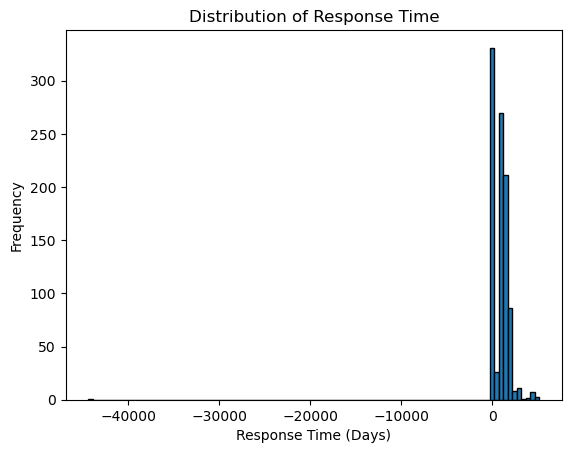

In [11]:
plt.hist(df['response_time'].dropna(), bins=100, edgecolor='k')
plt.xlabel('Response Time (Days)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Time')
plt.show()

## Data Cleaning

In [13]:
df = df[df['response_time'] > 0]  # Filter out negative values and invalid/cancelled requests (response time = 0)

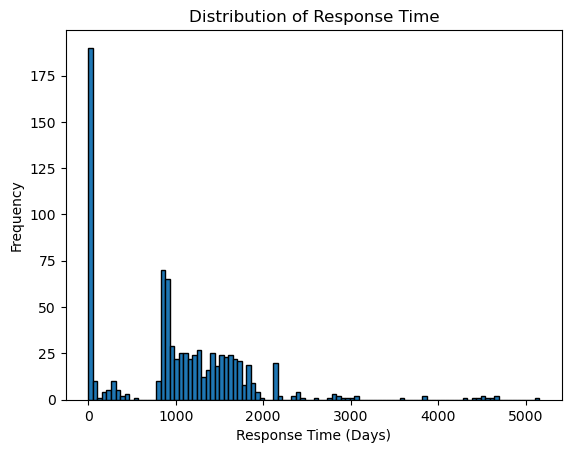

In [14]:
plt.hist(df['response_time'].dropna(), bins=100, edgecolor='k')
plt.xlabel('Response Time (Days)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Time')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_5036\1035530145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_response_time'] = np.log1p(df['response_time'])  # log(1 + x) to avoid log(0)


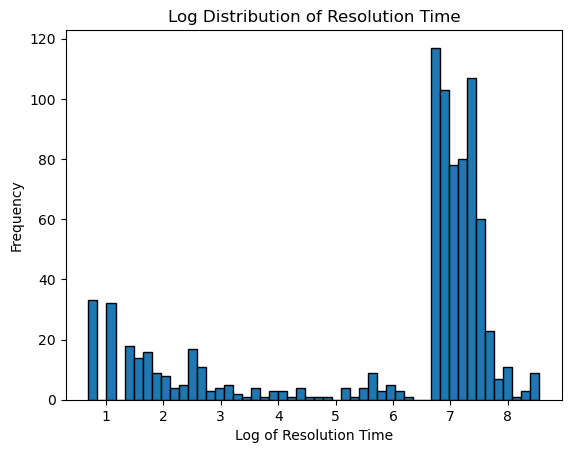

In [15]:
import numpy as np
# Plot log of resolution time
df['log_response_time'] = np.log1p(df['response_time'])  # log(1 + x) to avoid log(0)
plt.hist(df['log_response_time'].dropna(), bins=50, edgecolor='k')
plt.xlabel('Log of Resolution Time')
plt.ylabel('Frequency')
plt.title('Log Distribution of Resolution Time')
plt.show()

### Split into short term and long term service requests

In [17]:
short_term=df[df['response_time'] <= 365]
long_term=df[df['response_time'] > 365]
print("Short-term Service Responses = "+str(len(short_term)))
print("Long-term Service Responses = "+str(len(long_term)))

Short-term Service Responses = 225
Long-term Service Responses = 605


#### Short-term Service Response Times Distributions

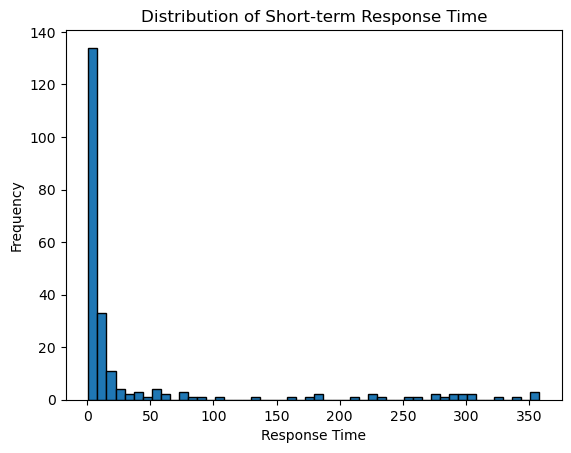

In [19]:
# Plot log of resolution time
plt.hist(short_term['response_time'].dropna(), bins=50, edgecolor='k')
plt.xlabel('Response Time')
plt.ylabel('Frequency')
plt.title('Distribution of Short-term Response Time')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_5036\2089928207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_term['log_response_time'] = np.log1p(short_term['response_time'])  # log(1 + x) to avoid log(0)


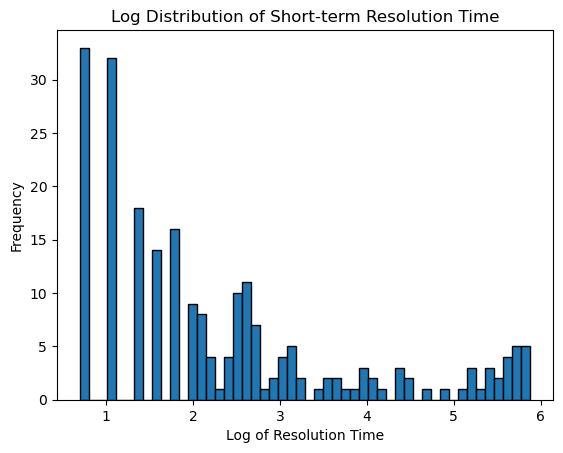

In [20]:
# Plot log of resolution time
short_term['log_response_time'] = np.log1p(short_term['response_time'])  # log(1 + x) to avoid log(0)
plt.hist(short_term['log_response_time'].dropna(), bins=50, edgecolor='k')
plt.xlabel('Log of Resolution Time')
plt.ylabel('Frequency')
plt.title('Log Distribution of Short-term Resolution Time')
plt.show()

### Long-term

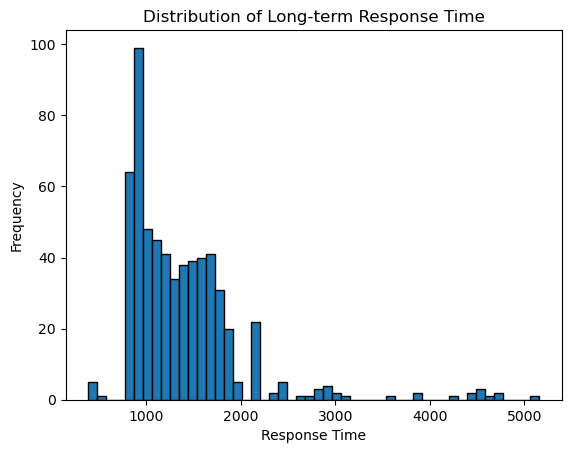

In [22]:
import numpy as np
# Plot log of resolution time
plt.hist(long_term['response_time'].dropna(), bins=50, edgecolor='k')
plt.xlabel('Response Time')
plt.ylabel('Frequency')
plt.title('Distribution of Long-term Response Time')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_5036\2774566931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_term['log_response_time'] = np.log1p(long_term['response_time'])  # log(1 + x) to avoid log(0)


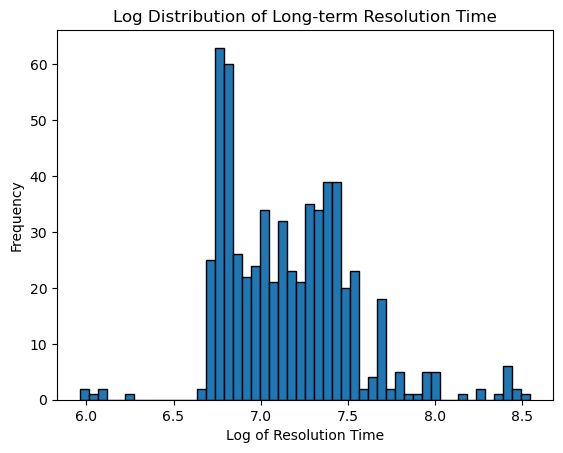

In [23]:
import numpy as np
# Plot log of resolution time
long_term['log_response_time'] = np.log1p(long_term['response_time'])  # log(1 + x) to avoid log(0)
plt.hist(long_term['log_response_time'].dropna(), bins=50, edgecolor='k')
plt.xlabel('Log of Resolution Time')
plt.ylabel('Frequency')
plt.title('Log Distribution of Long-term Resolution Time')
plt.show()

## Split Response times into Buckets

C:\Users\User\AppData\Local\Temp\ipykernel_5036\3169504804.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["response_time_category"] = pd.cut(


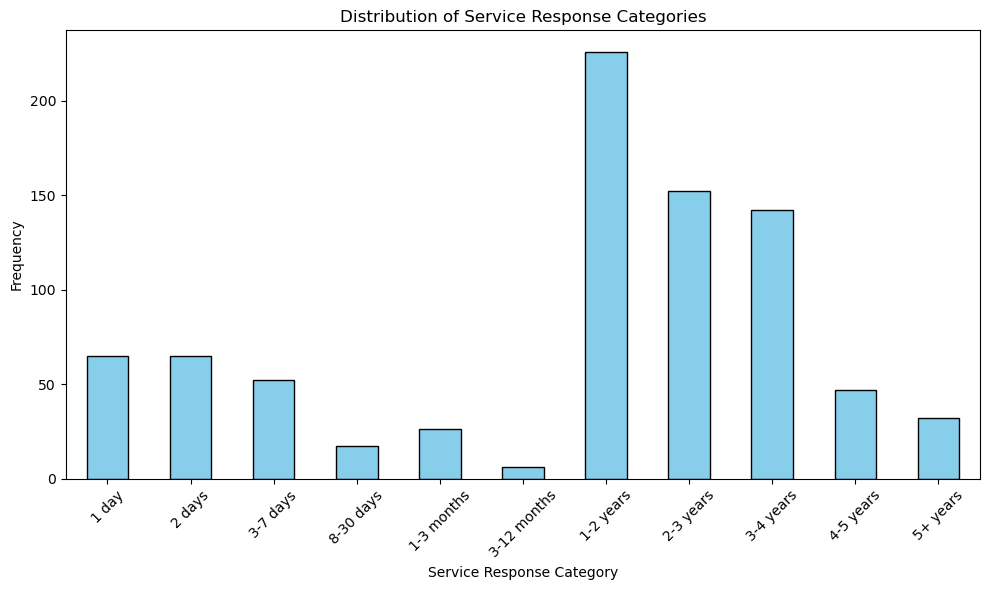

In [25]:
# Define Ranges
bins = [
    0.5, 2.5, 7.5, 30.5, 90.5, 365.5, 730.5, 
    1095.5, 1460.5, 1825.5, 2190.5, np.inf
]

# Define Categories
labels = [
    "1 day", "2 days", "3-7 days", "8-30 days", "1-3 months", "3-12 months",
    "1-2 years", "2-3 years", "3-4 years", "4-5 years", "5+ years"
]

# Categorize service response time into categories
df["response_time_category"] = pd.cut(
    df["response_time"], bins=bins, labels=labels, right=False
)

# Compute distribution
distribution = df["response_time_category"].value_counts().sort_index()

# Plot distribution
plt.figure(figsize=(10, 6))
distribution.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Service Response Category")
plt.ylabel("Frequency")
plt.title("Distribution of Service Response Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyze other columns in the data and check for missing values and too many unique values

In [27]:
df_summary = model_helper.describe_dataframe(df)
df_summary

,Column Name,Type,Missing Values,Missing %,Unique Values,Unique %,Most Frequent Value,Frequency,Statistics
0,__id,Categorical,0,0.0,830,100.0,row-226k.udpr.bug5,1,N/A
1,unique_key,Categorical,0,0.0,830,100.0,18449337,1,N/A
2,created_date,Numerical,0,0.0,800,96.0,N/A,N/A,"{'Mean': 2020-07-16 10:00:06.973494016, 'Min':..."
3,closed_date,Numerical,0,0.0,751,90.0,N/A,N/A,"{'Mean': 2023-05-03 00:09:41.822891264, 'Min':..."
4,agency,Categorical,0,0.0,11,1.33,DPR,511,N/A
5,agency_name,Categorical,0,0.0,11,1.33,Department of Parks and Recreation,511,N/A
6,complaint_type,Categorical,0,0.0,58,6.99,New Tree Request,398,N/A
7,descriptor,Categorical,19,2.0,126,15.18,For One Address,398,N/A
8,location_type,Categorical,148,18.0,13,1.57,Street,476,N/A
9,incident_zip,Categorical,24,3.0,150,18.07,11234,57,N/A


In [28]:
# disregard columns that are not expected to be available when a new service request in created
cols_to_drop=['status', 'agency_name', 'location',  'Due Date', 'resolution_description', 'resolution_action_updated_date', 'response_time', 'log_response_time']

In [29]:
# Get columns where Missing % is 50 or more or unique % is 80 or more
missing_50_or_more, unique_80_or_more = df_summary[df_summary['Missing %'].apply(pd.to_numeric, errors='coerce') >= 50]['Column Name'].tolist(), df_summary[df_summary['Unique %'].apply(pd.to_numeric, errors='coerce') >= 80]['Column Name'].tolist()

In [30]:
filtered_columns = [col for col in df.columns if col not in cols_to_drop + missing_50_or_more + unique_80_or_more]
filtered_columns

['agency',
 'complaint_type',
 'descriptor',
 'location_type',
 'incident_zip',
 'street_name',
 'cross_street_1',
 'cross_street_2',
 'intersection_street_1',
 'intersection_street_2',
 'address_type',
 'city',
 'landmark',
 'community_board',
 'bbl',
 'borough',
 'open_data_channel_type',
 'park_facility_name',
 'park_borough',
 'response_time_category']

# Data Cleaning

In [32]:
# remove rows where location is empty and city / borough are Unspecified
df = df[~((df['latitude'].isna()) & (df['borough'] == "Unspecified"))]
# impute missing values for city from park_borough and from google maps based on the location coordinates
df['city'] = df['city'].fillna(df['park_borough'])
city_mapping = {
    50781908: "QUEENS VILLAGE",
    54424243: "QUEENS",
    54424248: "WOODSIDE",
    54424265: "LONG ISLAND CITY",
    54424271: "QUEENS"
}
df.loc[df['unique_key'].isin(city_mapping.keys()), 'city'] = df['unique_key'].map(city_mapping)

In [33]:
# Merge complaint_type values meaning the same thing
df['complaint_type'] = df['complaint_type'].replace({
    "Dirty Condition": "Dirty Conditions",
    "Electrical": "ELECTRIC",
    "Missed Collection (All Materials)": "Missed Collection"
})

# Feature Engineering

### Add Weather conditions for first 2 days from Service Creation Data

In [36]:
df = model_helper.impute_missing_coordinates(df)
# read the weather details from a spreadsheet as it takes over 20 mins to populate
weather_df=pd.read_excel('weather.xlsx')
df["unique_key"] = df["unique_key"].astype(str)
weather_df["unique_key"] = weather_df["unique_key"].astype(str)
df = df.merge(weather_df[['unique_key', 'weather_condition']], on='unique_key', how='inner')
df

,__id,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,...,longitude,location,location_address,location_city,location_state,location_zip,response_time,log_response_time,response_time_category,weather_condition
0,row-5b6p_nsgn~5dxk,57488375,2023-05-02 20:51:21,2023-05-04 08:14:22,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10075,...,-73.953246,"{'type': 'Point', 'coordinates': [-73.95324625...",,,,,1.0,0.693147,1 day,Rain
1,row-3zt8_zgyj_znsv,19413730,2010-12-20 10:42:08,2010-12-23 00:00:00,DOB,Department of Buildings,Building/Use,No Certificate Of Occupancy/Illegal/Contrary T...,None,10451,...,-73.914931,"{'type': 'Point', 'coordinates': [-73.91493090...",,,,,2.0,1.098612,1 day,Clear
2,row-k7ec_tajp-7qp4,20424757,2011-03-18 11:18:05,2024-01-22 00:00:00,DOB,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,None,11377,...,-73.911845,"{'type': 'Point', 'coordinates': [-73.91184453...",,,,,4692.0,8.453827,5+ years,Clear
3,row-jhyr-x9d7~ua7y,20426581,2011-03-29 14:53:17,2024-01-22 00:00:00,DOB,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,None,11369,...,-73.872089,"{'type': 'Point', 'coordinates': [-73.87208890...",,,,,4681.0,8.451481,5+ years,Rain
4,row-rpvz-gcu2-tg4x,21102696,2011-08-24 11:17:03,2011-12-07 00:00:00,DOB,Department of Buildings,General Construction/Plumbing,Fence - None/Inadequate,None,11234,...,-73.908715,"{'type': 'Point', 'coordinates': [-73.90871469...",,,,,104.0,4.653960,1-3 months,Rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,row-rvhj_7ckn.8u7u,51050765,2021-06-29 20:28:26,2023-10-23 08:28:38,DPR,Department of Parks and Recreation,New Tree Request,For One Address,Street,11432,...,-73.789335,"{'type': 'Point', 'coordinates': [-73.78933505...",,,,,845.0,6.740519,1-2 years,Rain
822,row-9k5s~deeh-pwwj,51052472,2021-06-29 16:03:46,2023-10-23 08:28:44,DPR,Department of Parks and Recreation,New Tree Request,For One Address,Street,11432,...,-73.789331,"{'type': 'Point', 'coordinates': [-73.78933143...",,,,,845.0,6.740519,1-2 years,Rain
823,row-jmb2~k4v8.x7e8,51053659,2021-06-30 13:35:30,2023-09-05 13:28:55,DPR,Department of Parks and Recreation,Overgrown Tree/Branches,Blocking Street,Street,11228,...,-74.014950,"{'type': 'Point', 'coordinates': [-74.01494961...",,,,,796.0,6.680855,1-2 years,Rain
824,row-sgu9.dy6f.efhx,58215002,2023-07-16 09:05:00,2024-02-26 10:35:00,DOT,Department of Transportation,Traffic Signal Condition,Veh Signal Lamp,None,10006,...,-74.013591,"{'type': 'Point', 'coordinates': [-74.01359073...",,,,,225.0,5.420535,1-3 months,Rain


In [74]:
"""
# impute location coordinates for rows where the city is populated from coordinates of similar rows in the same city
df = model_helper.enrich_df_with_worst_weather(df[0:10])
# keep repeating until all rows are populated
while not df[df['weather_condition'] == 'Unknown'].empty:
    time.sleep(3)
    df.loc[df['weather_condition'] == 'Unknown', :] = enrich_df_with_worst_weather(
    df[df['weather_condition'] == 'Unknown']
)
df['weather_condition'].value_counts()
"""

weather_condition
Rain     8
Clear    2
Name: count, dtype: int64

### Add Season at time of Service Creation Date

In [39]:
df = model_helper.add_season_column(df)
df[["created_date", "season"]]

,created_date,season
0,2023-05-02 20:51:21,Spring
1,2010-12-20 10:42:08,Winter
2,2011-03-18 11:18:05,Winter
3,2011-03-29 14:53:17,Winter
4,2011-08-24 11:17:03,Summer
...,...,...
821,2021-06-29 20:28:26,Summer
822,2021-06-29 16:03:46,Summer
823,2021-06-30 13:35:30,Summer
824,2023-07-16 09:05:00,Summer


### Add number of service requests by agency created on the same date

In [41]:
df['n_requests_by_agency'] = df.apply(lambda row: count_active(row, df), axis=1)

In [70]:
df.n_requests_by_agency.value_counts()

n_requests_by_agency
4      26
2      19
3      18
8      18
10     17
       ..
194     1
193     1
192     1
191     1
503     1
Name: count, Length: 507, dtype: int64

# Data Preparation

### Impute Missing Values with Unspecified

In [45]:
# Get columns from col_to_predict_on that contain null values
cols_with_nulls = [col for col in filtered_columns if df[col].isna().sum() > 0]

# Set null values in those columns to "Unspecified"
df[cols_with_nulls] = df[cols_with_nulls].fillna("Unspecified")

In [46]:
categorical_cols=['weather_condition', 'season', 'agency', 'complaint_type', 'descriptor', 'location_type', 
                  'incident_zip', 'street_name', 'cross_street_1', 'cross_street_2', 'intersection_street_1',
                  'intersection_street_2', 'address_type', 'city', 'landmark', 'resolution_description', 
                  'community_board', 'bbl', 'borough', 'open_data_channel_type', 'park_facility_name', 'park_borough']

numerical_cols=['n_requests_by_agency']
label_col=['response_time_category']

## One-hot Encode Categorical Features

In [48]:
# Split the data (stratified) into 85% 15% to test the model on unseen data
X = df[categorical_cols + numerical_cols]
y = df[label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                    stratify=y, random_state=42)

# Preprocessing: OneHotEncode categorical features and scale numerical features
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# Modelling

In [50]:
# List of classifier models to try.
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('KNeighbors', KNeighborsClassifier()),
    ('SVC', SVC(probability=True, random_state=42)),
]

results = []

# Iterate over each model, create a pipeline, and record performance.
for name, clf in models:
    # Build pipeline with preprocessor and classifier
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predict on test set
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100  # percentage

    results.append({
        'Model': name,
        'Accuracy (%)': round(acc, 2),
        'Train Time (s)': round(train_time, 4)
    })

# Create a results table
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy (%)', ascending=False))


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

                 Model  Accuracy (%)  Train Time (s)
1        Decision Tree         79.03          0.0889
3    Gradient Boosting         78.23         58.1065
2        Random Forest         74.19          0.7777
0  Logistic Regression         73.39          1.2659
5                  SVC         73.39          6.5172
4           KNeighbors         58.87          0.0333


In [51]:
# Build the pipeline with preprocessing and DecisionTreeClassifier
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the hyperparameter grid for DecisionTree Classifier
param_grid = {
    'classifier__max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 20, 25, 30, 36, 40, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
start_time = time.time()
grid_search.fit(X_train, y_train)
grid_train_time = time.time() - start_time

# Get best model and performance on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred) * 100

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("Training Time: {:.4f} seconds".format(grid_train_time))


Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best Hyperparameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Cross-Validation Accuracy: 76.64%
Test Accuracy: 81.45%
Training Time: 14.4694 seconds


## Build the optimal decision tree model

In [53]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=15, 
        min_samples_leaf=1, 
        min_samples_split=2, 
        random_state=42
    ))
])

# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


Test Accuracy: 81.45%
